In [1]:
%load_ext autoreload
%autoreload 2

import pickle

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import LSQUnivariateSpline, interp1d

import time

import agama
# working units: 1 Msun, 1 kpc, 1 km/s
agama.setUnits(length=1, velocity=1, mass=1)

import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

from astropy.constants import G
from astropy import units as u
G = G.to(u.kpc*(u.km/u.s)**2/u.Msun)#.value

from Agama_dynesty import prior_transform, model, log_likelihood_MSE, get_data
from Agama_stream import Agama_stream, Agama_orbit

plt.rcParams.update({'font.size': 16})

In [2]:
def unwrap(r, theta, gamma):
    theta[theta < 0] += 2*np.pi
    unwrapped_theta = np.unwrap(theta)
    if np.any(unwrapped_theta < 0):
        return np.flip(r), np.unwrap(np.flip(theta)), np.flip(gamma)
    else:
        return r, unwrapped_theta, gamma

<ErrorbarContainer object of 3 artists>

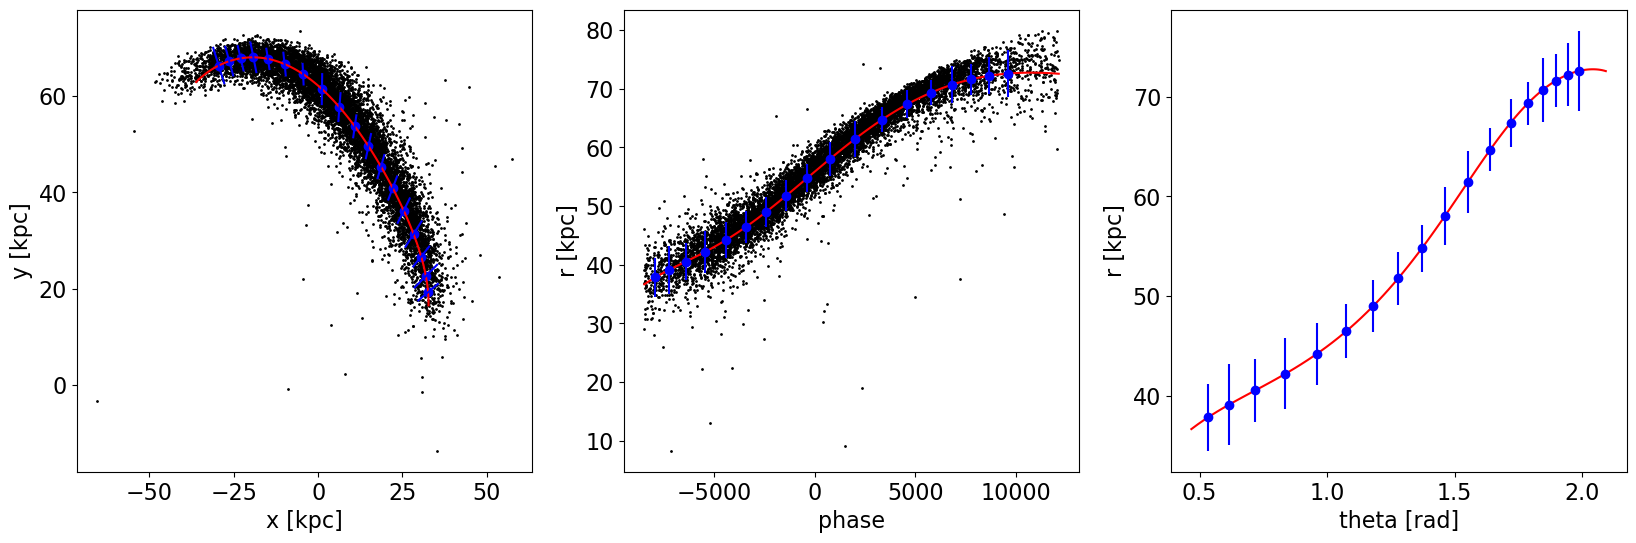

In [422]:
# Data
# params_data = np.array([12, 15, 0.9, 0.8, 8, 1, -40, 0, 0, 0, 150, 0, 2, 0.5, 0.2, 0.7])
params_data = np.array([11.64848174,   7.18141379,   0.9       ,   0.7       ,
                        8.33922279,   4.37097874, -58.83102067,  48.03176151,
                        29.39342699,  49.08774331,   7.90657151,  15.36507198,
                        2.25147559,   0.42901312,   0.79650598,   0.76345656])

ndim = 16
N_data = 20
seed=False
mean_p=0.9
mean_q=0.7
std_p=None
std_q=None
min_length=10
max_length=100
min_theta=np.pi/2
max_theta=5*np.pi/2

d_length = 0
theta_length = 0
theta_track_data = np.array([0])
while d_length < min_length or theta_length < min_theta or max_length < d_length or max_theta < theta_length or np.any( np.diff(theta_track_data) < 0): 

    if seed:
        params_data = np.array([12, 15, 0.9, 0.8, 8, 2, -40, 0, 0, 0, 150, 0, 2, 0.5, 0.2, 0.7])

    else:
        p = np.random.uniform(0, 1, ndim)
        params_data = np.array(prior_transform(p))
        if mean_p!=None or mean_q!=None:
            if std_p==None or std_q==None:
                params_data[2] = mean_p
                params_data[3] = mean_q
            else: 
                params_data[2] = np.random.normal(mean_p, std_p)
                params_data[3] = np.random.normal(mean_q, std_q)


    xy_stream_data, xy_track_data, gamma, gamma_track = model(params_data, N_stars=500, Nbody=False, seed=False)
    r_stream_data = np.sqrt(xy_stream_data[0]**2 + xy_stream_data[1]**2)
    r_track_data = np.sqrt(xy_track_data[0]**2 + xy_track_data[1]**2)
    theta_track_data = np.arctan2(xy_track_data[1], xy_track_data[0])
    r_track_data, theta_track_data, gamma_track = unwrap(r_track_data, theta_track_data, gamma_track)

    arc_lengths = abs(r_track_data[:-1] * np.diff(theta_track_data))
    cumulative_arc_lengths = np.concatenate([[0], np.cumsum(arc_lengths)])
    d_length     = cumulative_arc_lengths[-1]
    theta_length = abs(theta_track_data.max() - theta_track_data.min())

# Get full N-body data
xy_stream_data, xy_track_data, gamma, gamma_track = model(params_data, N_stars=10000, Nbody=True, seed=False)
r_stream_data = np.sqrt(xy_stream_data[0]**2 + xy_stream_data[1]**2)
r_track_data = np.sqrt(xy_track_data[0]**2 + xy_track_data[1]**2)
theta_track_data = np.arctan2(xy_track_data[1], xy_track_data[0])
r_track_data, theta_track_data, gamma_track = unwrap(r_track_data, theta_track_data, gamma_track)

d = d_length/N_data  # kpc -- Desired fixed distance
fixed_distances = np.arange(d, cumulative_arc_lengths[-1]-d, d)

interp_theta = interp1d(cumulative_arc_lengths, theta_track_data, kind='cubic')
interp_gamma = interp1d(cumulative_arc_lengths, gamma_track, kind='cubic')
theta_data = interp_theta(fixed_distances)
gamma_data = interp_gamma(fixed_distances)

f = interp1d(theta_track_data, r_track_data, kind='cubic')
r_data = f(theta_data)

N_data  = []
N_pred  = []
r_sigma = []
for i in range(len(gamma_data)):
    if i == 0:
        dgamma = (gamma_data[i+1] - gamma_data[i])/2
        gamma_1, gamma_2 = gamma_data[i]-dgamma, gamma_data[i]+dgamma
        gamma_min, gamma_max = min(gamma_1, gamma_2), max(gamma_1, gamma_2)
    elif i == len(gamma_data)-1:
        dgamma = (gamma_data[i] - gamma_data[i-1])/2
        gamma_1, gamma_2 = gamma_data[i]-dgamma, gamma_data[i]+dgamma
        gamma_min, gamma_max = min(gamma_1, gamma_2), max(gamma_1, gamma_2)
    else:
        dgamma_min = (gamma_data[i] - gamma_data[i-1])/2
        dgamma_max = (gamma_data[i+1] - gamma_data[i])/2
        gamma_1, gamma_2 = gamma_data[i]-dgamma_min, gamma_data[i]+dgamma_max
        gamma_min, gamma_max = min(gamma_1, gamma_2), max(gamma_1, gamma_2)
    arg_in = np.where((gamma>gamma_min) & (gamma<gamma_max))[0]
    N_data.append(len(arg_in))
    N_pred.append(len(arg_in) * 500/10000)
    r_sigma.append(np.std(r_stream_data[arg_in]))
N_data = np.array(N_data)
N_pred = np.array(N_pred)
r_sigma = np.array(r_sigma)#/np.sqrt(N_data)

x_data = r_data * np.cos(theta_data)
y_data = r_data * np.sin(theta_data)

dict_data = {'theta': theta_data,
            'r': r_data,
            'r_sigma': r_sigma,
            'x': x_data,
            'y': y_data}

plt.figure(figsize=(20, 6))
plt.subplot(1,3,1)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.scatter(xy_stream_data[0], xy_stream_data[1], s=1, c='k')
plt.plot(xy_track_data[0], xy_track_data[1], c='r')
x_data = r_data*np.cos(theta_data)
y_data = r_data*np.sin(theta_data)
x_sigma = abs(r_sigma*np.cos(theta_data))
y_sigma = abs(r_sigma*np.sin(theta_data))
for i in range(len(theta_data)):
    xerr = r_sigma[i] * np.cos(theta_data[i])
    yerr = r_sigma[i] * np.sin(theta_data[i])
    plt.plot([x_data[i] - xerr, x_data[i] + xerr], [y_data[i] - yerr, y_data[i] + yerr], 'blue')
plt.scatter(x_data, y_data, c='blue')
plt.subplot(1,3,2)
plt.xlabel('phase')
plt.ylabel('r [kpc]')
plt.scatter(gamma, r_stream_data, s=1, c='k')
plt.plot(gamma_track, r_track_data, c='r')
plt.errorbar(gamma_data, r_data, yerr=r_sigma, c='blue', fmt='o')
plt.subplot(1,3,3)
plt.xlabel('theta [rad]')
plt.ylabel('r [kpc]')
plt.plot(theta_track_data, r_track_data, c='r')
plt.errorbar(theta_data, r_data, yerr=r_sigma, c='blue', fmt='o')

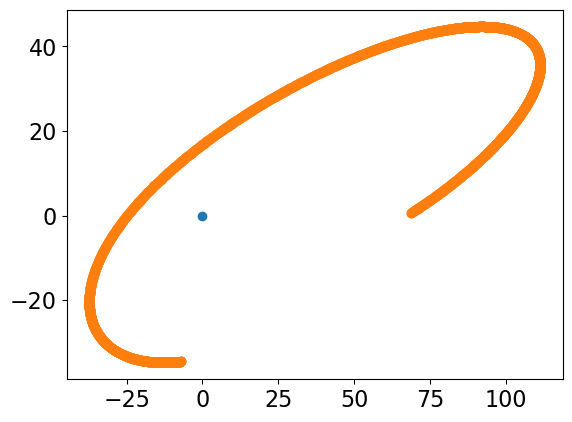

In [13]:
from Agama_dynesty_orbit_2D import get_data_orbit, model, prior_transform
import numpy as np
import matplotlib.pyplot as plt

ndim = 13
p = np.random.uniform(0, 1, ndim)
params = prior_transform(p)
x, y = model(params)
plt.scatter(0, 0)
plt.scatter(x,y)

In [14]:
r = np.sqrt(x**2 + y**2)
theta = np.unwrap(np.arctan2(y, x))

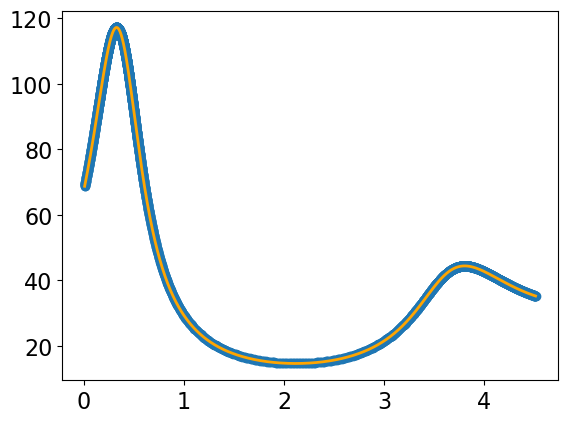

In [32]:
plt.scatter(theta, r)

import scipy
def get_interpol(ang, R):
    if ang[1] < ang[0]:
        ang = ang[::-1]

    II = scipy.interpolate.CubicSpline(ang, R)
    return II

theta_fit = np.linspace(theta.min(), theta.max(), 1000)
r_fit = get_interpol(theta, r)(theta_fit)
plt.plot(theta_fit, r_fit, color='orange', linewidth=2) 